In [1]:
####### Use Selenium to open webpages that use java script rendering ###############
from selenium import webdriver
####### Use Pandas to manage and arrange data #################
import pandas as pd
####### Use BeautifulSoup to read and navigate the DOM ################
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.request
import urllib.error
######### Use Regex to clean up some of the elements we scrape #################
import re
########## Use Numpy for data manipulation ###############
import numpy as np
########## Use the nltk library to tokenize and analyse text results ##########
import nltk
from nltk.tokenize import sent_tokenize
############# Use Networks for graphing of text analysis #############
import networkx as nx
############# use Matplotlib and WordCloud to create and display a wordcloud ################
import matplotlib as plt
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
############## Download these files if they are not upto date #############
# nltk.download('stopwords')
# nltk.download('punkt')

In [28]:
############# First we ask for user input of what topics should be searches/how many pages of Google reuslts they would like/ and how recent the results should be limited to ######################
results = []
pages = []
allsellers = []
links = []
terms = input('Enter what you would like to search : ')
terms = terms.split(', ')
length = input('How many pages would you like to search : ')
length = int(length)
recency = input('How recently do you want results from? Select h/d/w/m/y :  ')
recency = str(recency)
i = 0
############# for each search term entered run the for loop to gather the search results #########
############# 'i' represents the number of pages requested so a wdecreasing while loop will gather the needed reults ###############
for t in terms:
    while i < length:
        i += 1
        pnum = str(1-i)
        driver = webdriver.Chrome()
        base = 'https://www.google.com/search?q='
        time = ('&tbs=qdr:'+recency)
        depth = '&start='+pnum+'0'
        url = base+t+time+depth
        driver.implicitly_wait(30)
        driver.get(url)
        soup=BeautifulSoup(driver.page_source, 'html.parser')
        results=soup.find_all('div',{'class':'r'})
        
        for link in results:
            links.extend(link.find_all('a'))
        links=[re.sub(r'.*href\=\"',r'',str(a))for a in links]
        links=[re.sub(r'".*',r'',str(a))for a in links]
        while '#' in links:
            links.remove('#')
        driver.quit()
############ once we have gathered all of the links from the pages into a list we can claen them and remove unwanted domians ###########        
links = [re.sub(r'.*https',r'https',str(a))for a in links]
links = [re.sub(r'\/search\?q\=related\:',r'https\:\/\/',str(a))for a in links]
links = [x for x in links if 'wikipedia' not in x]
links = [x for x in links if 'encyclopedia' not in x]
print(len(links))
links = [re.sub(r'\+\&amp.*',r'',str(a))for a in links]
links=set(links)
print(len(links))

Enter what you would like to search : christmas deals
How many pages would you like to search : 1
How recently do you want results from? Select h/d/w/m/y :  h
17
9


In [29]:
################ this function will look at the parent element tags and filter out ones that are irrelivant #############
def visable(element):
    if element.parent.name in ['style', 'script', ['document'], 'head', 'title', 'meta']:
        return False
    elif re.match(r'<!--.*-->',str(element.encode('utf-8'))):
        return False
    return True

In [4]:
print(links)

{'https://www.heatherdisarro.com/is-celery-juice-really-a-fresh-squeezed-miracle/', 'https://www.shape.com/healthy-eating/healthy-drinks/celery-juice-food-trend', 'https://www.bravotv.com/the-real-housewives-of-beverly-hills/the-feast/kyle-richards-instagram-juice-diet', 'http://thechalkboardmag.com/6-surprising-things-happen-drink-celery-juice', 'https://www.livescience.com/50640-celery-nutrition.html', 'https://www.instagram.com/medicalmedium/p/BquuqZ9Frj4/?hl=en', 'https://www.produceretailer.com/article/news-article/what-you-need-know-about-celery-juice-trend', 'https://www.wellandgood.com/good-food/is-celery-juice-healthy/', 'https://www.summitmedicalgroup.com/library/medications/pma_celery/', 'https://blogs.webmd.com/food-and-nutrition/2018/11/celery-juice-are-the-health-claims-real.html', 'https://www.instagram.com/medicalmedium/p/Bq7YDDTlX0R/', 'https://www.foodnetwork.com/healthyeats/news/2018/12/is-celery-juice-healthy', 'https://www.mamamia.com.au/celery-juice-benefits/'}


In [30]:
############### Now that the links have been cleaned we can open each page and scrape the 'visable' ellements for the text #################
corpus = []
art = links
for url in art:
    ################## we first try to access the page with BeautifulSoup because it is faster #############
    ################## if it errors out we will try to open it with Selenium to render javascript ############
    ################## if both methods fail we will skip the page ###############
    try:
        page = urllib.request.urlopen(url)
        soup = BeautifulSoup(page, 'html.parser')
        data = soup.findAll(test=True)
        result = filter(visable, data)
        result = [re.sub(r'\n',r'',str(a))for a in result]
        result = [re.sub(r'.*src\=.*',r'',str(a))for a in result]
        result = [re.sub(r'\t',r'',str(a))for a in result]
        result = [re.sub(r'\<.*\>',r'',str(a))for a in result]
        result = [re.sub(r'\{.*\}',r'',str(a))for a in result]
        while '' in result:
            result.remove('')
        corpus.appen(result)
    except:
        driver=webdriver.Chrome()
        driver.implicitly_wait(30)
        try:
            driver.get(url)
            soup=BeautifulSoup(driver.page_source, 'html.parser')
            driver.quit()
            data = soup.findAll(text = True)

            result = filter(visable, data)
            result = [re.sub(r'\n',r'',str(a))for a in result]
            result = [re.sub(r'.*src\=.*',r'',str(a))for a in result]
            result = [re.sub(r'\t',r'',str(a))for a in result]
            result = [re.sub(r'\<.*\>',r'',str(a))for a in result]
            result = [re.sub(r'\{.*\}',r'',str(a))for a in result]
            while '' in result:
                result.remove('')
            corpus.append(result)
        except:
            result = 'Bad URL at : ' + url
            corpus.append(result)
print(len(corpus))

9


In [6]:
text=corpus

In [7]:
############# in an effort to remove visable text that is unrealted to the page content like social media links and ads we filter out stings less than 100 charcters. ##############
############# NOTE: this may also remove <li> elements or other relevant but very short elements on the page ###############
final = []
for i in text:
    temp = []
    for x in i:
#         print(len(x))
        s = len(x)
        if s > 100:
#             y = [re.sub(r'.*',r'',str(a))for a in x]
#             while '' in y:
#                 y.remove('')
            temp.append(x)
        else:
            x=1
    final.append(temp)

In [28]:
print(final)

[["A holiday government shutdown appeared more likely on Thursday after President Donald Trump informed House Republicans he would refuse to accept a stop-gap measure -- already passed by the Senate -- that doesn't include funds for his long-promised border wall.", ' at another agreement that stops short of providing the $5 billion the President has demanded for the border.', "It was a closing burst of wrath in the final days of the Republican-majority House. If Trump cannot secure the money he is demanding for the wall now, it's unlikely he will see a spending bill that meets his requirement for at least two years as Democrats assume control.", "The uncertainty sent lawmakers scrambling to devise a solution that could keep funds flowing to some government agencies after Friday's deadline. It's not clear if there are enough votes in the House for a bill that would include the $5 billion in border wall funding; in the Senate, where any measure will require 60 votes to clear procedural h

In [8]:
############## Create a single string per page ##############
df = [''.join(x)for x in final]

In [9]:
############# Tokenize the results ########################
sentences = []
for s in df:
  sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x] # flatten list

In [10]:
print(len(sentences))

467


In [11]:
########## Extract word vectors from GloVe file ##################3
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [12]:
##################### remove punctuations, numbers and special characters ####################
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

############ make alphabets lowercase ##################
clean_sentences = [s.lower() for s in clean_sentences]

In [13]:
############## import stopwords  list (or create your own)#####################
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [14]:
##################### this function will remove stopwords ####################
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [15]:
############## remove stopwords from the sentences ######################
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [26]:
########### create a vector for the sentences using the GloVe vector library and pulled text ##############
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [17]:
############## create a similarity matrix ################
sim_mat = np.zeros([len(sentences), len(sentences)])

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
########## perform cosine-similarity for vectors #############
for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]


In [21]:
########### rank pages based on cosine similarity ##########
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

In [22]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

NameError: name 'scores' is not defined

In [22]:
############ Extract top 10 sentences as the summary #################
for i in range(10):
  print(ranked_sentences[i][1])

The Edge also touts improved cargo capacity over its smaller Escape sibling.In an effort to appeal to a wide range of buyers, every vehicle in the Ford lineup now offers several different engine options -- and the Escape and Edge are no different.Both the Escape and Edge offer three engines.
That means that you can get a used SUV that's essentially the same as the new model for potentially much less money.We analyzed 28 Ford Edge reviews – along with safety and reliability ratings, fuel economy estimates, and more – to help you decide if the 2018 Edge is the right new car for you.This overview incorporates applicable data and reviews from all model years of the current generation, which spans the 2015 through 2018 model years.U.S.
Factor in the extra standard equipment and you have a compelling offering for those who don't want or need a large three-row vehicle like the Explorer or Expedition.
While the Escape boasts a backup camera, the Edge also has a highly useful 180-degree camera 

In [50]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

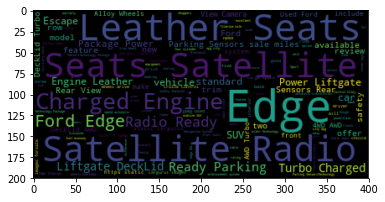

In [23]:
########### create word cloud for ranked sentences #############
wctext = ranked_sentences
wctext = str(wctext)
wordcloud = WordCloud().generate(wctext)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show